## 5 Layer MLP w/AlignMNIST

75 epochs of RMSProp

In [3]:
import tensorflow as tf
import numpy as np

In [5]:
%run augmentmnist.py

In [6]:
num_epochs = 75
batch_size = 125

learning_rate = 0.001

In [7]:
# Network Parameters
n_hidden_1 = 2500
n_hidden_2 = 1500
n_hidden_3 = 1000
n_hidden_4 = 500
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# maybe there is a better initialization?
std_0 = 1.0/np.sqrt(n_input)
std_h1 = 1.0/np.sqrt(n_hidden_1)
std_h2 = 1.0/np.sqrt(n_hidden_2)
std_h3 = 1.0/np.sqrt(n_hidden_3)
std_h4 = 1.0/np.sqrt(n_hidden_4)

logfile = "5-layer-mlp-alignmnist"

In [8]:
# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

xt = tf.placeholder("float", [None, n_input])
yt = tf.placeholder("float", [None, n_classes])

In [9]:
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2'])) 
    layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, _weights['h3']), _biases['b3'])) 
    layer_4 = tf.nn.relu(tf.add(tf.matmul(layer_3, _weights['h4']), _biases['b4'])) 
    return tf.matmul(layer_4, weights['out']) + biases['out']

In [10]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=std_0)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=std_h1)),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], stddev=std_h2)),
    'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4], stddev=std_h3)),
    'out': tf.Variable(tf.random_normal([n_hidden_4, n_classes], stddev=std_h4))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], stddev=0.1)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2], stddev=0.01)),
    'b3': tf.Variable(tf.random_normal([n_hidden_3], stddev=0.01)),
    'b4': tf.Variable(tf.random_normal([n_hidden_4], stddev=0.01)),
    'out': tf.Variable(tf.random_normal([n_classes], stddev=0.001))
}

In [11]:
mlp = multilayer_perceptron(x, weights, biases )
mlp_test = multilayer_perceptron(xt, weights, biases )

In [12]:
cost =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(mlp, y)) 
gs = tf.get_variable("global_step",[],trainable=False,initializer=tf.constant_initializer(0))
lr = tf.constant(learning_rate) 

In [13]:
train_op = tf.contrib.layers.optimize_loss(cost, global_step=gs, learning_rate=lr,optimizer="RMSProp")

In [14]:
#with tf.name_scope("training accuracy"):
pred = tf.equal(tf.argmax(mlp, 1), tf.argmax(y, 1)) # Count correct predictions
train_acc_op = tf.reduce_mean(tf.cast(pred, "float"))  # Cast boolean to float to average
tf.scalar_summary("training accuracy", train_acc_op)

<tf.Tensor 'ScalarSummary_2:0' shape=() dtype=string>

In [15]:
test_pred = tf.equal(tf.argmax(mlp_test, 1), tf.argmax(yt, 1)) # Count correct predictions
test_acc_op = tf.reduce_mean(tf.cast(test_pred, "float"))  # Cast boolean to float to average
tf.scalar_summary("test 0 accuracy", test_acc_op)

<tf.Tensor 'ScalarSummary_3:0' shape=() dtype=string>

In [16]:
!rm -rf ./logs/{logfile}
!ls logs

### Original MNIST Data

In [17]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(".", one_hot=True)
trX_0, trY_0 = mnist.train.images, mnist.train.labels
teX_0, teY_0 = mnist.test.images, mnist.test.labels

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


### Train on AlignMNIST

In [19]:
alignmnist = AlignMNIST()

In [21]:
test_accuracies = []
train_accuracies = []
with tf.Session() as sess:
    # create a log writer. run 'tensorboard --logdir=./logs/{logfile}'
    writer = tf.train.SummaryWriter("./logs/{0}".format(logfile), sess.graph) # for 0.8
    merged = tf.merge_all_summaries()
 
    tf.initialize_all_variables().run()

    for epoch in range(num_epochs):
        trX, trY = alignmnist.next_epoch()
      
        for start, end in zip(range(0, len(trX), batch_size), range(batch_size, len(trX), batch_size)):
            sess.run(train_op, feed_dict={x: trX[start:end], y: trY[start:end]})
                 
        summary, trn_acc, tst_acc = sess.run([merged, train_acc_op, test_acc_op], feed_dict={x: trX, y: trY, xt: teX_0, yt: teY_0})
        writer.add_summary(summary, epoch)  
        
        #print(epoch, trn_acc, tst_acc)
        train_accuracies.append(trn_acc)
        test_accuracies.append(tst_acc)

        writer.flush()
        

In [22]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

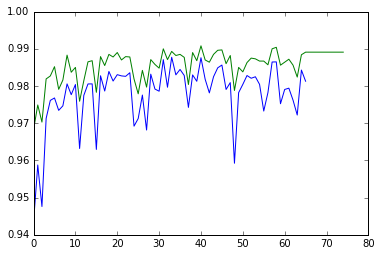

In [23]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)

In [24]:
plt.show()

### the best error is

In [25]:
np.max(test_accuracies)

0.99080002